In [1]:
# Clase diff robot

#module that define a 2D differential robot

#@author: Javier Luiso
#"""

import numpy as np
import matplotlib.image as pimg
# from enum import Enum
import math
import threading
import time
import timeit
import json

from json import encoder
encoder.FLOAT_REPR = lambda o: format(o, '.2f')

class LidarTask():
    def __init__(self, robot):
        self.running = True
        self.robot = robot

    def run(self):
        while self.running == True:
            elapsed_time = timeit.timeit(self.robot.doLIDARMeasure, number=1)
            print(elapsed_time)
            time.sleep(0.127)
        print ("finishing LidarTask...")

    def terminate(self): 
        self.running = False


class DiffRobot():
    def __init__(self, x=0, y=0, theta=0):
        #The robot pose comprises its two-dimensional planar coordinates relative to
        #an external coordinate frame, along with its angular orientation.
        #time step for simulation is setted to default value 1 seg.
        self.__ground_truth = (x, y, theta)
        self.__odometry = (x, y, theta)
        #self.dt = 1.0
        self.dt = 0.1
        
        #Kinematics parameters 
        #values expressed in meters
        #self.r = 0.072
        self.r = 0.036
        self.l = 0.235

        #Robot dimensions
        #Robot shape = cylinder
        #values expressed in meters
        self.height = 0.10
        self.diameter = 0.35

        #Error parameters
        self.alpha = (0.10, 0.20, 0.10, 0.20, 0.25, 0.25)

        #Occupation Map
        self.occupation_map_loaded = False
        self.occupation_map_scale = 0

        #Sensores
        # BUMPER
        # a value == True means next robot ground_truth value has reached an occupied cell (collision)
        self.__collision_detected = False
        # Sensor activate status
        self.__bumper_sensor_enabled = False
        # A value == True means sensor is pressed, the robot has collided against an obstacle
        self.__bumper_sensor_value = False
        # If bumper is enabled and robot has collided, while tetha is quadrant marked as True, the robot only will accept v < 0.
        self.__theta_qudrants_stopped = (False, False, False, False)
        # If robot reach map_border
        self.__map_border = False

        # LIDAR
        # Lidar position (L_x, L_y, L_theta) respect robot ground_truth.
        self.__lidar_pos = (0.09, 0.0, math.pi)
        self.__lidar_dr_center_robot = 0.00
        self.__lidar_resolution = 144
        self.__lidar_measure = np.zeros(self.__lidar_resolution)
        # Lidar thread
        self.__lidar_sensor_enabled = True


        # Simulation Thread
        self.__continue_running = False
        self.__input_v = 0.0
        self.__input_w = 0.0
        self.__simulation_thread = threading.Thread(target=self.__simulationTask) 
        self.__print_status = False
        self.__step_counter = 0
        self.__simulation_paused = False

        # Record Robot Stauts
        self.__record_status_on =  False
        self.__status_history = []
        


    #private methods
    def __sample_nd(self, b):
        return (b / 6.0) * np.sum(2.0 * np.random.rand(12) - 1.0)


    def __raycast(self, x, y, theta):
        dx = math.cos(theta) *  self.occupation_map_scale
        dy = math.sin(theta) *  self.occupation_map_scale
        free_pos = True
        out_of_map = False

        next_x = x
        next_y = y
        last_free_pos_x = x
        last_free_pos_y = y
        while free_pos == True and out_of_map == False:
            last_free_pos_x = next_x
            last_free_pos_y = next_y
            next_x += dx
            next_y += dy
            (free_pos, out_of_map) = self.__isItFreePosition(next_x, next_y)
            if free_pos == False or out_of_map == True:
                next_x = last_free_pos_x
                next_y = last_free_pos_y
                free_pos = True
                out_of_map = False
                ddx = dx / 8
                ddy = dy / 8
                while free_pos == True and out_of_map == False:
                    last_free_pos_x = next_x
                    last_free_pos_y = next_y
                    next_x += ddx
                    next_y += ddy
                    (free_pos, out_of_map) = self.__isItFreePosition(next_x, next_y)
            else:
                pass
        
        distance_measured = math.sqrt((last_free_pos_x - x)**2 + (last_free_pos_y - y)**2)
        #error = np.random.normal(scale = 0.015 * distance_measured)
        error = np.random.normal(scale = 0.15 * distance_measured)
        return  distance_measured + self.__lidar_dr_center_robot + error


    def __doLIDARMeasure(self):
        dtheta = 2 * math.pi / self.__lidar_resolution
        lidar_angle = 0
        measure_values = np.zeros(self.__lidar_resolution)
        for i in range(0, self.__lidar_resolution):
            measure_values[i] = self.__raycast(self.__ground_truth[0], self.__ground_truth[1], self.__ground_truth[2] - self.__lidar_pos[2] + lidar_angle)
            lidar_angle += dtheta

        self.__lidar_measure = measure_values
        return measure_values
        
    def printStatus(self, elapsed_time):
        if self.__collision_detected == True:
            print('{:d} dt={:.{prec}f} u_t=({:.{prec}f} {:.{prec}f}) GT=({:.{prec}f} {:.{prec}f} {:.{prec1}f} deg) OD=({:.{prec}f} {:.{prec}f} {:.{prec1}f} deg) B={:d} MP={:d} COLLISION'.format(
            self.__step_counter, elapsed_time, self.__input_v, self.__input_w,
            self.__ground_truth[0], self.__ground_truth[1], self.__ground_truth[2]*180 / np.pi,
            self.__odometry[0], self.__odometry[1], self.__odometry[2]*180 / np.pi, self.__bumper_sensor_value, self.__map_border, prec=2, prec1=0))
        else:
            print('{:d} dt={:.{prec}f} u_t=({:.{prec}f} {:.{prec}f}) GT=({:.{prec}f} {:.{prec}f} {:.{prec1}f} deg) OD=({:.{prec}f} {:.{prec}f} {:.{prec1}f} deg) B={:d} MP={:d}'.format(
            self.__step_counter, elapsed_time, self.__input_v, self.__input_w,
            self.__ground_truth[0], self.__ground_truth[1], self.__ground_truth[2]*180 / np.pi,
            self.__odometry[0], self.__odometry[1], self.__odometry[2]*180 / np.pi, self.__bumper_sensor_value, self.__map_border, prec=2, prec1=0))

    def __recordStatus(self):
        status_entry = []

        # Entry Type
        status_entry.append('SIM_STEP')
        # Step counter
        status_entry.append(self.__step_counter)
        # dt value
        status_entry.append(self.dt)
        # Input
        status_entry.append([self.__input_v, self.__input_w])
        # Ground truth
        status_entry.append(self.__ground_truth)
        # Odometry
        status_entry.append(self.__odometry)
        # Bumper sensor status
        status_entry.append(self.__bumper_sensor_enabled)
        # Bumper sensor value
        status_entry.append(self.__bumper_sensor_value)
        # Collision detected
        status_entry.append(self.__collision_detected)
        # Map border status
        status_entry.append(self.__map_border)
        # Lidar Sensor status
        status_entry.append(self.__lidar_sensor_enabled)

        if self.__lidar_sensor_enabled == True:
            status_entry.append(self.__lidar_measure.tolist())

        self.__status_history.append(status_entry)

    def __recordOccupationMap(self):
        occmap_record = []
        occmap_record.append('OCC_MAP')
        occmap_record.append(self.occupation_map_scale)
        occmap_record.append(self.occupation_map.tolist())

        self.__status_history.append(occmap_record)

    def __simulationStep(self):
        self.foward(self.__input_v, self.__input_w)
        self.__step_counter += 1
        lidar_measurement_time = 0.0
        if self.__lidar_sensor_enabled == True:
            lidar_measurement_time = timeit.timeit(self.__doLIDARMeasure, number=1)

        if self.__record_status_on == True:
            self.__recordStatus()

        time_to_sleep = self.dt - lidar_measurement_time
        if time_to_sleep > 0:
            time.sleep(time_to_sleep)
        else:
            time.sleep(0.010)

    def __simulationTask(self):
        while self.__continue_running == True:
            if self.__simulation_paused == False:
                elapsed_time = timeit.timeit(self.__simulationStep, number=1)
                if self.__print_status == True:
                    self.printStatus(elapsed_time)
            else:
                time.sleep(self.dt)
                
        print("finishing simulation thread...")
        return

    # Public Simulation Control Interface
    def startSimulation(self, print_status = False):
        if self.__continue_running == False:
            self.__print_status = print_status
            self.__continue_running = True
            self.__simulation_thread.start()
        self.__step_counter = 0

    def pauseSimulation(self):
        self.__simulation_paused = True

    def continueSimulation(self):
        self.__simulation_paused = False

    def stopSimulation(self):
        self.__continue_running = False
        self.__simulation_thread.join()
        print("Simulation Thread Stopped")

    def getSimStepCounter(self):
        return self.__step_counter

    def getSimulationTime(self):
        return self.__step_counter * self.dt

    # Public Lidar Control Interface
    def turnLidar_ON(self):
        self.__lidar_sensor_enabled = True
 
    def turnLidar_OFF(self):
        self.__lidar_sensor_enabled = True

    def getLidarMeaurement(self):
        return self.__lidar_measure

    def getLidarResolution(self):
        return self.__lidar_resolution

    # Public Record Status Interface
    def startRecordStatus(self):
        if self.__status_history:
            self.__status_history.clear()

        if self.occupation_map_loaded == True:
            self.__recordOccupationMap()

        self.__record_status_on = True

    def stopRecordStatus(self):
        self.__record_status_on = False

    def saveRecordStatus(self, filename):
        if self.__record_status_on == False:
            with open(filename, 'w') as outfile:
                json.dump(self.__status_history, outfile, indent=1)

    #public methods
    def setErrorParams(self, a1, a2, a3, a4, a5, a6):
        self.alpha = (a1, a2, a3, a4, a5, a6)

    def setTimeStep(self, t):
        self.dt = t

    def setLinearVelocity(self, v):
        self.__input_v = v

    def getLinearVelocity(self):
        return self.__input_v

    def getAngularVelocity(self):
        return self.__input_w

    def setAngularVelocity(self, w):
        self.__input_w = w

    def enableBumper(self):
        self.__bumper_sensor_enabled = True

    def disableBumper(self):
        self.__bumper_sensor_enabled = False

    def isBumperEnable(self):
        return self.__bumper_sensor_enabled

    def getBumperSensorValue(self):
        return self.__bumper_sensor_value

    def getTimeStep(self):
        return self.dt

    def getGroundTruth(self):
        return np.array(self.__ground_truth)

    def getOdometry(self):
        return np.array(self.__odometry)

    def foward(self, v, w):
        if self.__bumper_sensor_enabled == True:
            self.__foward_with_bummper(v, w)
        else:
            self.__foward_without_bummper(v, w)

        self.__normalizeThetaValues()
       
    # Occupation Map Interface   
    def loadOccupationMap(self, filename, scale):
        self.occupation_map = pimg.imread(filename)
        self.occupation_map_loaded = True
        self.occupation_map_scale = scale
        self.occupation_map_center = np.array(self.occupation_map.shape) / 2.0

    def getOccMapSizeInWorld(self):
        occ_map_width = self.occupation_map.shape[0] * self.occupation_map_scale
        occ_map_height = self.occupation_map.shape[1] * self.occupation_map_scale
        return (occ_map_width, occ_map_height)

    def getOccMap(self):
        return self.occupation_map

    # Simulation utility functions
    def __normalizeThetaValues(self):
        gt_theta = self.__ground_truth[2]
        od_theta = self.__odometry[2]
        while gt_theta > math.pi:
            gt_theta -= 2 * math.pi
        
        while gt_theta < -math.pi:
            gt_theta += 2 * math.pi

        while od_theta > math.pi:
            od_theta -= 2 * math.pi
        
        while od_theta < -math.pi:
            od_theta += 2 * math.pi

        self.__ground_truth = (self.__ground_truth[0], self.__ground_truth[1], gt_theta)
        self.__odometry = (self.__odometry[0], self.__odometry[1], od_theta)
              
    def __foward_without_bummper(self, v, w):
        #compute odometry
        if abs(w) > 0:
            v_w = v / w
            next_odom_x = self.__odometry[0] - v_w * np.sin(self.__odometry[2]) + v_w * np.sin(self.__odometry[2] + w * self.dt)
            next_odom_y = self.__odometry[1] + v_w * np.cos(self.__odometry[2]) - v_w * np.cos(self.__odometry[2] + w * self.dt)
            next_odom_theta = self.__odometry[2] + w * self.dt
        else:
            next_odom_x = self.__odometry[0]
            next_odom_y = self.__odometry[1]
            next_odom_theta = self.__odometry[2]

        #compute next ground truth
        v_hat = v + self.__sample_nd(self.alpha[0] * np.abs(v) + self.alpha[1] * np.abs(w))
        w_hat = w + self.__sample_nd(self.alpha[2] * np.abs(v) + self.alpha[3] * np.abs(w))
        gamma_hat = self.__sample_nd(self.alpha[4] * np.abs(v) + self.alpha[5] * np.abs(w))

        if abs(w_hat) > 0:
            v_w = (v_hat / w_hat)
            next_gt_x = self.__ground_truth[0] - v_w * np.sin(self.__ground_truth[2]) + v_w * np.sin(self.__ground_truth[2] + w * self.dt)
            next_gt_y = self.__ground_truth[1] + v_w * np.cos(self.__ground_truth[2]) - v_w * np.cos(self.__ground_truth[2] + w * self.dt)
            next_gt_theta = self.__ground_truth[2] + w_hat * self.dt + gamma_hat * self.dt
        else:
            next_gt_x = self.__ground_truth[0]
            next_gt_y = self.__ground_truth[1]
            next_gt_theta = self.__ground_truth[2]

        iteration_counter = 8
        self.__collision_detected = False
        self.__theta_qudrants_stopped = (False, False, False, False)
        self.__ground_truth = self.__checkForCollision(next_gt_x, next_gt_y, next_gt_theta, v_hat, w_hat, gamma_hat, self.dt, iteration_counter)

        if self.__collision_detected == True:
            self.__ground_truth = (self.__ground_truth[0], self.__ground_truth[1], next_gt_theta)

        self.__odometry = (next_odom_x, next_odom_y, next_odom_theta)
        

    def __foward_with_bummper(self, v, w):
        current_gt = self.__ground_truth
        
        if self.__bumper_sensor_value == False:
            #compute odometry
            if abs(w) > 0:
                v_w = v / w
                next_odom_x = self.__odometry[0] - v_w * np.sin(self.__odometry[2]) + v_w * np.sin(self.__odometry[2] + w * self.dt)
                next_odom_y = self.__odometry[1] + v_w * np.cos(self.__odometry[2]) - v_w * np.cos(self.__odometry[2] + w * self.dt)
                next_odom_theta = self.__odometry[2] + w * self.dt
            else:
                next_odom_x = self.__odometry[0] + v * np.cos(self.__odometry[2]) * self.dt
                next_odom_y = self.__odometry[1] + v * np.sin(self.__odometry[2]) * self.dt
                next_odom_theta = self.__odometry[2]

            #compute next ground truth
            v_hat = v + self.__sample_nd(self.alpha[0] * np.abs(v) + self.alpha[1] * np.abs(w))
            w_hat = w + self.__sample_nd(self.alpha[2] * np.abs(v) + self.alpha[3] * np.abs(w))
            gamma_hat = self.__sample_nd(self.alpha[4] * np.abs(v) + self.alpha[5] * np.abs(w))

            if abs(w_hat) > 0:
                v_w = (v_hat / w_hat)
                next_gt_x = self.__ground_truth[0] - v_w * np.sin(self.__ground_truth[2]) + v_w * np.sin(self.__ground_truth[2] + w_hat * self.dt)
                next_gt_y = self.__ground_truth[1] + v_w * np.cos(self.__ground_truth[2]) - v_w * np.cos(self.__ground_truth[2] + w_hat * self.dt)
                next_gt_theta = self.__ground_truth[2] + w_hat * self.dt + gamma_hat * self.dt
            else:
                next_gt_x = self.__ground_truth[0] + v_hat * np.cos(self.__ground_truth[2]) * self.dt
                next_gt_y = self.__ground_truth[1] + v_hat * np.sin(self.__ground_truth[2]) * self.dt
                next_gt_theta = self.__ground_truth[2] + gamma_hat * self.dt

            iteration_counter = 8
            self.__collision_detected = False
            self.__theta_qudrants_stopped = (False, False, False, False)
            self.__ground_truth = self.__checkForCollision(next_gt_x, next_gt_y, next_gt_theta, v_hat, w_hat, gamma_hat, self.dt, iteration_counter)
            
            if self.__collision_detected == True:
                self.__bumper_sensor_value = True

            self.__odometry = (next_odom_x, next_odom_y, next_odom_theta)

        else:
            # chequear theta para ver si adminitmos valores positivo de v
            can_move_forward = False

            if self.__gt_theta_in_1st_cuadrant() == True:
                if self.__theta_qudrants_stopped[0] == True:
                    can_move_forward = False
                else:
                    can_move_forward = True

            elif self.__gt_theta_in_2nd_cuadrant() == True:
                if self.__theta_qudrants_stopped[1] == True:
                    can_move_forward = False
                else:
                    can_move_forward = True

            elif self.__gt_theta_in_3th_cuadrant() == True:
                if self.__theta_qudrants_stopped[2] == True:
                    can_move_forward = False
                else:
                    can_move_forward = True
            elif self.__gt_theta_in_4th_cuadrant() == True:
                if self.__theta_qudrants_stopped[3] == True:
                    can_move_forward = False
                else:
                    can_move_forward = True
            else:
                pass

            if can_move_forward == False:
                if v > 0:
                    next_odom_theta = self.__odometry[2] + w * self.dt
                    w_hat = w + self.__sample_nd(self.alpha[3] * np.abs(w))
                    gamma_hat = self.__sample_nd(self.alpha[5] * np.abs(w))
                    next_gt_theta = self.__ground_truth[2] + w_hat * self.dt + gamma_hat * self.dt

                    self.__ground_truth = (self.__ground_truth[0], self.__ground_truth[1], next_gt_theta)
                    self.__odometry = (self.__odometry[0], self.__odometry[1], next_odom_theta)
                else:
                    if abs(w) > 0:
                        v_w = v / w
                        next_odom_x = self.__odometry[0] - v_w * np.sin(self.__odometry[2]) + v_w * np.sin(self.__odometry[2] + w * self.dt)
                        next_odom_y = self.__odometry[1] + v_w * np.cos(self.__odometry[2]) - v_w * np.cos(self.__odometry[2] + w * self.dt)
                        next_odom_theta = self.__odometry[2] + w * self.dt
                    else:
                        next_odom_x = self.__odometry[0]
                        next_odom_y = self.__odometry[1]
                        next_odom_theta = self.__odometry[2]

                    #compute next ground truth
                    v_hat = v + self.__sample_nd(self.alpha[0] * np.abs(v) + self.alpha[1] * np.abs(w))
                    w_hat = w + self.__sample_nd(self.alpha[2] * np.abs(v) + self.alpha[3] * np.abs(w))
                    gamma_hat = self.__sample_nd(self.alpha[4] * np.abs(v) + self.alpha[5] * np.abs(w))

                    if abs(w_hat) > 0:
                        v_w = (v_hat / w_hat)
                        next_gt_x = self.__ground_truth[0] - v_w * np.sin(self.__ground_truth[2]) + v_w * np.sin(self.__ground_truth[2] + w * self.dt)
                        next_gt_y = self.__ground_truth[1] + v_w * np.cos(self.__ground_truth[2]) - v_w * np.cos(self.__ground_truth[2] + w * self.dt)
                        next_gt_theta = self.__ground_truth[2] + w_hat * self.dt + gamma_hat * self.dt
                    else:
                        next_gt_x = self.__ground_truth[0]
                        next_gt_y = self.__ground_truth[1]
                        next_gt_theta = self.__ground_truth[2]

                    iteration_counter = 8
                    self.__collision_detected = False
                    self.__theta_qudrants_stopped = (False, False, False, False)
                    self.__ground_truth = self.__checkForCollision(next_gt_x, next_gt_y, next_gt_theta, v_hat, w_hat, gamma_hat, self.dt, iteration_counter)
                    self.__odometry = (next_odom_x, next_odom_y, next_odom_theta)
                    
                    if self.__collision_detected == True:
                        self.__ground_truth = current_gt
                    else:
                        self.__bumper_sensor_value = False

            else:

                #compute odometry
                if abs(w) > 0:
                    v_w = v / w
                    next_odom_x = self.__odometry[0] - v_w * np.sin(self.__odometry[2]) + v_w * np.sin(self.__odometry[2] + w * self.dt)
                    next_odom_y = self.__odometry[1] + v_w * np.cos(self.__odometry[2]) - v_w * np.cos(self.__odometry[2] + w * self.dt)
                    next_odom_theta = self.__odometry[2] + w * self.dt
                else:
                    next_odom_x = self.__odometry[0] + v * np.sin(self.__odometry[2])
                    next_odom_y = self.__odometry[1] + v * np.cos(self.__odometry[2])
                    next_odom_theta = self.__odometry[2]

                #compute next ground truth
                v_hat = v + self.__sample_nd(self.alpha[0] * np.abs(v) + self.alpha[1] * np.abs(w))
                w_hat = w + self.__sample_nd(self.alpha[2] * np.abs(v) + self.alpha[3] * np.abs(w))
                gamma_hat = self.__sample_nd(self.alpha[4] * np.abs(v) + self.alpha[5] * np.abs(w))

                if abs(w_hat) > 0:
                    v_w = (v_hat / w_hat)
                    next_gt_x = self.__ground_truth[0] - v_w * np.sin(self.__ground_truth[2]) + v_w * np.sin(self.__ground_truth[2] + w * self.dt)
                    next_gt_y = self.__ground_truth[1] + v_w * np.cos(self.__ground_truth[2]) - v_w * np.cos(self.__ground_truth[2] + w * self.dt)
                    next_gt_theta = self.__ground_truth[2] + w_hat * self.dt + gamma_hat * self.dt
                else:
                    next_gt_x = self.__ground_truth[0]
                    next_gt_y = self.__ground_truth[1]
                    next_gt_theta = self.__ground_truth[2]

                iteration_counter = 8
                self.__collision_detected = False
                self.__theta_qudrants_stopped = (False, False, False, False)
                self.__ground_truth = self.__checkForCollision(next_gt_x, next_gt_y, next_gt_theta, v_hat, w_hat, gamma_hat, self.dt, iteration_counter)
                
                if self.__collision_detected == True:
                    self.__bumper_sensor_value = True
                else:
                    self.__bumper_sensor_value = False

                self.__odometry = (next_odom_x, next_odom_y, next_odom_theta)

    def __calculateCellForPosition(self, x, y):
        norm_pos = np.array([x,y]) / self.occupation_map_scale
        pos_occmap = norm_pos + self.occupation_map_center

        if pos_occmap[1] > 0:
            row = int(self.occupation_map.shape[0] - pos_occmap[1])
        else:
            row = self.occupation_map.shape[0] + 1

        if pos_occmap[0] > 0:
            col = int(pos_occmap[0])
        else:
            col = -1
        return (row, col)

    def __gt_theta_in_1st_cuadrant(self):
        return 0 < self.__ground_truth[2] and self.__ground_truth[2] < math.pi/2

    def __gt_theta_in_2nd_cuadrant(self):
        return math.pi/2 < self.__ground_truth[2] and self.__ground_truth[2] < math.pi

    def __gt_theta_in_3th_cuadrant(self):
        return -math.pi < self.__ground_truth[2] and self.__ground_truth[2] < -math.pi/2

    def __gt_theta_in_4th_cuadrant(self):
        return -math.pi/2 < self.__ground_truth[2] and self.__ground_truth[2] < 0

    def __amIOutsideOccMap (self, x, y):
        out_of_map = True
        row = -1
        col = -1
        if self.occupation_map_loaded == True:
            (row, col) = self.__calculateCellForPosition(x, y)
            
            if row < 0 or row >= self.occupation_map.shape[0]:
                out_of_map = True
            elif col < 0 or col >= self.occupation_map.shape[1]:
                out_of_map = True
            else:
                out_of_map = False 
        else:
            out_of_map = True
        
        return (out_of_map, row, col)

    def __isItFreePosition(self, x, y):
        free_pos = False
        out_of_map = False
        if self.occupation_map_loaded == True:
            (out_of_map, row, col) = self.__amIOutsideOccMap(x,y)
            if  out_of_map == False:
                occ_map_value = self.occupation_map[row, col]
                if (occ_map_value < 0.5):
                    free_pos = False
                else:
                    free_pos = True
            else:
                free_pos = False
        else:
            free_pos = True

        return (free_pos, out_of_map)

    def __IamInFreeCell(self):
        (center_in_free_cell, out_of_map) = self.__isItFreePosition(self.__ground_truth[0], self.__ground_truth[1])
        robot_in_free_cell = False

        if center_in_free_cell == True:
            (top_border_in_free_cell, out_of_map) = self.__isItFreePosition(self.__ground_truth[0], self.__ground_truth[1] + self.diameter / 2.0)
            (bottom_border_in_free_cell, out_of_map) = self.__isItFreePosition(self.__ground_truth[0], self.__ground_truth[1] - self.diameter / 2.0)
            (left_border_in_free_cell, out_of_map) = self.__isItFreePosition(self.__ground_truth[0] - self.diameter / 2.0, self.__ground_truth[1])
            (right_border_in_free_cell, out_of_map) = self.__isItFreePosition(self.__ground_truth[0] + self.diameter / 2.0, self.__ground_truth[1])

            if top_border_in_free_cell and bottom_border_in_free_cell and left_border_in_free_cell and right_border_in_free_cell:
                robot_in_free_cell = True
            else:
                robot_in_free_cell = False

        else:
            robot_in_free_cell = False

        return (robot_in_free_cell, out_of_map)

    def __willBeInAFreeCell(self, next_gt_x, next_gt_y):
        (center_in_free_cell, out_of_map) = self.__isItFreePosition(next_gt_x, next_gt_y)
        robot_in_free_cell = False

        if center_in_free_cell == True:
            (top_border_in_free_cell, out_of_map) = self.__isItFreePosition(next_gt_x, next_gt_y + self.diameter / 2.0)
            (bottom_border_in_free_cell, out_of_map) = self.__isItFreePosition(next_gt_x, next_gt_y - self.diameter / 2.0)
            (left_border_in_free_cell, out_of_map) = self.__isItFreePosition(next_gt_x - self.diameter / 2.0, next_gt_y)
            (right_border_in_free_cell, out_of_map) = self.__isItFreePosition(next_gt_x + self.diameter / 2.0, next_gt_y)

            if top_border_in_free_cell and bottom_border_in_free_cell and left_border_in_free_cell and right_border_in_free_cell:
                robot_in_free_cell = True
            else:
                robot_in_free_cell = False
                if top_border_in_free_cell == False and (self.__gt_theta_in_1st_cuadrant() or self.__gt_theta_in_2nd_cuadrant()):
                    self.__theta_qudrants_stopped = (True, True, False, False)
                if bottom_border_in_free_cell == False and (self.__gt_theta_in_3th_cuadrant() or self.__gt_theta_in_4th_cuadrant()):
                    self.__theta_qudrants_stopped = (False, False, True, True)
                if left_border_in_free_cell == False and (self.__gt_theta_in_2nd_cuadrant() or self.__gt_theta_in_3th_cuadrant()):
                    self.__theta_qudrants_stopped = (False, True, True, False)
                if right_border_in_free_cell == False and (self.__gt_theta_in_1st_cuadrant() or self.__gt_theta_in_4th_cuadrant()):
                    self.__theta_qudrants_stopped = (True, False, False, True)
        else:
            robot_in_free_cell = False

        return (robot_in_free_cell, out_of_map)

    def __checkForCollision_old(self, next_gt_x, next_gt_y, next_gt_theta, v_hat, w_hat, gamma_hat, dt, iteration_counter):
        (robot_in_free_cell, out_of_map) = self.__willBeInAFreeCell(next_gt_x, next_gt_y)
        iteration_counter = iteration_counter - 1

        self.__map_border = out_of_map

        if abs(w_hat) > 0:
            if robot_in_free_cell == False:
                self.__collision_detected = True
                v_w = (v_hat / w_hat)
                n_gt_x = self.__ground_truth[0] - v_w * np.sin(self.__ground_truth[2]) + v_w * np.sin(self.__ground_truth[2] + w_hat * 0.9 * dt)
                n_gt_y = self.__ground_truth[1] + v_w * np.cos(self.__ground_truth[2]) - v_w * np.cos(self.__ground_truth[2] + w_hat * 0.9 * dt)
                n_gt_theta = self.__ground_truth[2] + w_hat * 0.9 * dt + gamma_hat * 0.9 * dt
                
                if iteration_counter > 0:
                    return self.__checkForCollision(n_gt_x, n_gt_y, next_gt_theta, v_hat, w_hat, gamma_hat, 0.9 * dt, iteration_counter)
                else:
                    self.__ground_truth = (self.__ground_truth[0], self.__ground_truth[1], next_gt_theta)
                    return self.__ground_truth

            else:
                if self.__collision_detected == True and iteration_counter > 0:
                    v_w = (v_hat / w_hat)
                    n_gt_x = self.__ground_truth[0] - v_w * np.sin(self.__ground_truth[2]) + v_w * np.sin(self.__ground_truth[2] + w_hat * 1.5 * dt)
                    n_gt_y = self.__ground_truth[1] + v_w * np.cos(self.__ground_truth[2]) - v_w * np.cos(self.__ground_truth[2] + w_hat * 1.5 * dt)
                    n_gt_theta = self.__ground_truth[2] + w_hat * dt/2 + gamma_hat * dt/2
                    return self.__checkForCollision(n_gt_x, n_gt_y, next_gt_theta, v_hat, w_hat, gamma_hat, 1.5 * dt, iteration_counter)
                else:
                    self.__ground_truth = (next_gt_x, next_gt_y, next_gt_theta)
       
        return self.__ground_truth

    def __checkForCollision(self, next_gt_x, next_gt_y, next_gt_theta, v_hat, w_hat, gamma_hat, dt, iteration_counter):
        (robot_in_free_cell, out_of_map) = self.__willBeInAFreeCell(next_gt_x, next_gt_y)

        iterations = 10
        dt_step = dt / iterations
        next_dt = 0
        last_know_free_gt = self.__ground_truth

        while robot_in_free_cell == False and iterations > 0:
            self.__collision_detected = True

            next_dt += dt_step
            v_w = (v_hat / w_hat)
            n_gt_x = self.__ground_truth[0] - v_w * np.sin(self.__ground_truth[2]) + v_w * np.sin(self.__ground_truth[2] + w_hat * next_dt)
            n_gt_y = self.__ground_truth[1] + v_w * np.cos(self.__ground_truth[2]) - v_w * np.cos(self.__ground_truth[2] + w_hat * next_dt)
            n_gt_theta = self.__ground_truth[2] + w_hat * next_dt + gamma_hat * next_dt
            (robot_in_free_cell, out_of_map) = self.__willBeInAFreeCell(n_gt_x, n_gt_y)
            if robot_in_free_cell == True:
                last_know_free_gt = (n_gt_x, n_gt_y, n_gt_theta)
            iterations -= 1

        if self.__collision_detected == True:
            self.__ground_truth = last_know_free_gt
        else:
            self.__ground_truth = (next_gt_x, next_gt_y, next_gt_theta)

        return self.__ground_truth


In [2]:
# clase particle filter

#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Mar  5 19:34:18 2021

@author: federico
"""


from math import *
#import math
import numpy as np
import numpy.linalg as lng
import argparse
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
# =============================================================================
# Clase partícula
# =============================================================================
class particle():
    def __init__(self):
        #self.x = np.random.uniform(-0.8,0.8)
        #self.y = np.random.uniform(-0.8,0.8)
        #self.theta = np.random.uniform(-np.pi,np.pi)

        self.x = 0
        self.y = 0
        self.theta = 0
        
        self.peso = 1.0
        
        # self.noise_param = alfa
        
        # self.lidar_resolution = l
        # self.lidar_pos = p
        
        # self.occupation_map_loaded = False
    # #========================================================================#
    # def loadoccmap(self,occupation_map,occupation_map_scale):
    #     self.occ_map = occupation_map
    #     self.occ_map_scale = occupation_map_scale
    #     self.occ_map_loaded = True
    #     self.occ_map_center = np.array(self.occ_map.shape) / 2.0
    
    #========================================================================#
    # modelo de movimiento de la partícula
    #def mov_odom(self,v_0,w_0,t,alfa_1,alfa_2,alfa_3,alfa_4):
    def mov_odom(self,v_0,w_0,t,alfa):

        v = v_0 + np.random.normal(0,alfa[0]*abs(v_0) + alfa[1]*abs(w_0))
        w = w_0 + np.random.normal(0,alfa[2]*abs(v_0) + alfa[3]*abs(w_0))
        #print(v,w)
        #gamma = gamma_0 + np.random.normal(0,alfa[4]*abs(v_0) + alfa[5]*abs(w_0))
        
        #if(w!=0):
        #    v_w = v/w

        #    x_new = self.x - v_w * np.sin(self.theta) + v_w * np.sin(self.theta + w * t)
        #    y_new = self.y + v_w * np.cos(self.theta) - v_w * np.cos(self.theta + w * t)
        #    theta_new = self.theta + w * t
        
        #else:
        #    x_new = self.x + v * np.cos(self.theta) * t
        #    y_new = self.y + v * np.sin(self.theta) * t
        #    theta_new = self.theta

        theta_new = self.theta + w * t
        x_new = self.x + v * cos(theta_new) * t
        y_new = self.y + v * sin(theta_new) * t
        
        self.x = x_new
        self.y = y_new

        while(theta_new > np.pi):
          theta_new -= 2 * np.pi
        while(theta_new < -np.pi):
          theta_new += 2 * np.pi

        self.theta = theta_new

        result = particle()
        result.x = x_new
        result.y = y_new
        result.theta = theta_new

        return result
        #print(x_new,y_new,theta_new)
# =============================================================================
# Clase filtro de partículas
# =============================================================================
class particle_filter():
    def __init__(self,N,alfa,l,p):
        
        # inicialización del filtro de partículas. Se crean "N" partículas en
        # poses aleatorias
        self.noise_param = alfa
        
        self.lidar_resolution = l
        self.lidar_pos = p
        
        self.occupation_map_loaded = False
        
        self.particles = []
        self.pesos = []
        
        for i in range(0,N):
            # creo una partícula
            p = particle()
            #p.loadoccmap(occupation_map,occupation_map_scale)
            self.particles.append(p)
            self.pesos.append(1.0)
        
        self.N = N
    #========================================================================#
    def entropia(self):
        H = 0
        for i in range(self.N):
            H -= np.log(self.particles[i].peso) * self.particles[i].peso
        
        return H
    #========================================================================#
    def mean_particle_pos(self):
        x_mean = 0
        y_mean = 0
        theta_mean = 0
        for i in range(self.N):
            x_mean = x_mean + self.particles[i].x
            y_mean = y_mean + self.particles[i].y
            theta_mean = theta_mean + self.particles[i].theta
        x_mean = x_mean / self.N
        y_mean = y_mean / self.N
        theta_mean = theta_mean / self.N
        
        pos_media = np.array([x_mean,y_mean,theta_mean])
        return pos_media
    #========================================================================#
    def best_particle_pos(self):

        peso_max = self.particles[0].peso
        best_particle = 0

        for i in range(1,self.N):
            peso_new = self.particles[i].peso
            if(peso_new > peso_max):
                peso_max = peso_new
                best_particle = i
        
        return np.array([self.particles[i].x,self.particles[i].y,self.particles[i].theta])
    #========================================================================#
    def std_err_particle_pos(self):
        # obengo la media
        mu = self.mean_particle_pos()
        #mu = self.best_particle_pos()
        #x_std = 0
        #y_std = 0
        dist = 0
        for i in range(self.N):
            #x_std = x_std + (self.particles[i].x - mu[0])**2
            #y_std = y_std + (self.particles[i].y - mu[1])**2
            dist = dist + (self.particles[i].x - mu[0])**2 + (self.particles[i].y - mu[1])**2
        
        #x_std = np.sqrt((1/self.N) * x_std)
        #y_std = np.sqrt((1/self.N) * y_std)
        desvio = np.sqrt(dist / self.N)
        
        #desvio = np.array([x_std,y_std])
        return desvio
        
    #========================================================================#
    def loadoccmap(self,occupation_map,occupation_map_scale):
        self.occ_map = occupation_map
        self.occ_map_scale = occupation_map_scale
        self.occ_map_loaded = True
        self.occ_map_center = np.array(self.occ_map.shape) / 2.0     
    #========================================================================#
    def __calculateCellForPosition(self, x, y):
        norm_pos = np.array([x,y]) / self.occ_map_scale
        pos_occmap = norm_pos + self.occ_map_center

        if pos_occmap[1] > 0:
            row = int(self.occ_map.shape[0] - pos_occmap[1])
        else:
            row = self.occ_map.shape[0] + 1

        if pos_occmap[0] > 0:
            col = int(pos_occmap[0])
        else:
            col = -1
        return (row, col)
    #========================================================================#
    def __amIOutsideOccMap (self, x, y):
        out_of_map = True
        row = -1
        col = -1
        if self.occ_map_loaded == True:
            (row, col) = self.__calculateCellForPosition(x, y)
            
            if row < 0 or row >= self.occ_map.shape[0]:
                out_of_map = True
            elif col < 0 or col >= self.occ_map.shape[1]:
                out_of_map = True
            else:
                out_of_map = False 
        else:
            out_of_map = True
        
        return (out_of_map, row, col)
    #========================================================================#
    def __isItFreePosition(self, x, y):
        free_pos = False
        out_of_map = False
        if self.occ_map_loaded == True:
            (out_of_map, row, col) = self.__amIOutsideOccMap(x,y)
            if  out_of_map == False:
                occ_map_value = self.occ_map[row, col]
                if (occ_map_value < 0.5):
                    free_pos = False
                else:
                    free_pos = True
            else:
                free_pos = False
        else:
            free_pos = True

        return (free_pos, out_of_map)
    #========================================================================#
    def ray_casting(self, x, y, theta):
        # dx = math.cos(theta) *  self.occ_map_scale
        # dy = math.sin(theta) *  self.occ_map_scale
        # dx = np.cos(theta) *  self.occ_map_scale
        # dy = np.sin(theta) *  self.occ_map_scale
        dx = np.cos(theta) *  0.2
        dy = np.sin(theta) *  0.2
        free_pos = True
        out_of_map = False

        next_x = x
        next_y = y
        last_free_pos_x = x
        last_free_pos_y = y
        while free_pos == True and out_of_map == False:
            last_free_pos_x = next_x
            last_free_pos_y = next_y
            next_x += dx
            next_y += dy
            (free_pos, out_of_map) = self.__isItFreePosition(next_x, next_y)
            #if free_pos == False or out_of_map == True:
            #    next_x = last_free_pos_x
            #    next_y = last_free_pos_y
            #    free_pos = True
            #    out_of_map = False
            #    ddx = dx / 8
            #    ddy = dy / 8
            #    while free_pos == True and out_of_map == False:
            #       last_free_pos_x = next_x
            #        last_free_pos_y = next_y
            #        next_x += ddx
            #        next_y += ddy
            #        (free_pos, out_of_map) = self.__isItFreePosition(next_x, next_y)
            #else:
            #    pass
        
        distance_measured = np.sqrt((last_free_pos_x - x)**2 + (last_free_pos_y - y)**2)
        #error = np.random.normal(scale = 0.015 * distance_measured)
        # error = np.random.normal(scale = 0.15 * distance_measured)
        return  distance_measured
    #========================================================================#
    def medicion_esperada(self,x,y,theta,paso):
        # dtheta = 2 * math.pi / self.lidar_resolution
        dtheta = 2 * np.pi / self.lidar_resolution
        dtheta = paso * dtheta
        lidar_angle = 0
        measure_values = np.zeros(int(self.lidar_resolution / paso))
        for i in range(0, int(self.lidar_resolution / paso)):
            measure_values[i] = self.ray_casting(x, y, theta - self.lidar_pos[2] + lidar_angle)
            lidar_angle += dtheta
        return measure_values
    #========================================================================#
    def crear_nube_puntos(self,vector):
        
        N = len(vector)
        nube = np.zeros((2,N))
        
        dtheta = 2 * np.pi / N
        lidar_angle = 0
        
        for i in range(N):
            x_i = vector[i] * np.cos(lidar_angle - self.lidar_pos[2])
            y_i = vector[i] * np.sin(lidar_angle - self.lidar_pos[2])
            nube[0,i] = x_i
            nube[1,i] = y_i
            lidar_angle += dtheta
        return nube
    #========================================================================#
    def closest_point_matching(self,X, P):
      """Performs closest point matching of two point sets.
      
      Arguments:
      X -- reference point set
      P -- point set to be matched with the reference
      
      Output:
      P_matched -- reordered P, so that the elements in P match the elements in X
      """
      
      P_matched = P.copy()
      
      # cantidad de puntos
      N = X.shape[1]
      orden = np.random.permutation(N)
      for l in range(0,N):
          # elijo un punto de la nube de puntos
          i = orden[l]
          x_i = X[:,i]
          # busco el punto más cercano
          dist_min = np.linalg.norm(x_i - P_matched[:,i])
          k = i
          for m in range(l+1,N):
              j = orden[m]
              dist = np.linalg.norm(x_i - P_matched[:,j])
              if(dist<dist_min):
                  x_aux = X[:,j]
                  p_aux = P_matched[:,i]
                  delta_E = dist - dist_min - np.linalg.norm(x_aux - P_matched[:,j]) + np.linalg.norm(x_aux - p_aux)
                  if(delta_E < 0):
                      dist_min = dist
                      k = j
          aux = P_matched[:,k].copy()
          P_matched[:,k] = P_matched[:,i].copy()
          P_matched[:,i] = aux
              
      return P_matched
    
    #========================================================================#
    def matchear_mediciones(self,nube_h_original,nube_measurements,N):

        # creo las nubes de puntos sub muestreadas
        #nube_measurements_sub = self.sub_muestrar(nube_measurements,N)

        e_old = 1000
        for i in range(3):
            
            #calculate RMSE
            e = 0
            for j in range(0,nube_h_original.shape[1]):
                
              e = e+(nube_h_original[0,j]-nube_measurements[0,j])**2 + (nube_h_original[1,j]-nube_measurements[1,j])**2
            
            e = np.sqrt(e/nube_h_original.shape[1])
            #print("error icp: ", e)
            if(abs(e - e_old) < 1e-2):
                break
            
            e_old = e
            
            #nube_h_sub = self.sub_muestrar(nube_h_original,N)
            
            nube_h_original = self.closest_point_matching(nube_measurements,nube_h_original)
            #nube_h_sub = self.closest_point_matching(nube_measurements_sub,nube_h_sub)
            
            #substract center of mass
            mx = np.transpose([np.mean(nube_measurements,1)])
            mp = np.transpose([np.mean(nube_h_original,1)])
            X_prime = nube_measurements-mx
            P_prime = nube_h_original-mp
            
            # mx = np.transpose([np.mean(nube_measurements_sub,1)])
            # mp = np.transpose([np.mean(nube_h_sub,1)])
            # X_prime = nube_measurements_sub-mx
            # P_prime = nube_h_sub-mp
            
            #singular value decomposition
            W = np.dot(X_prime,np.transpose(P_prime))
            U, s, V = np.linalg.svd(W)
    
            #calculate rotation and translation
            R = np.dot(U,np.transpose(V))
            t = mx-np.dot(R,mp)
        
            #apply transformation
            nube_h_original = np.dot(R,nube_h_original)+t
            
        return nube_h_original
    #========================================================================#
    def resample_particles(self,w):
        #w_max = w[0]
        #pos_max = 0
        # print(w)
        #for i in range(1,len(w)):
        #    if(w[i] > w_max):
        #        w_max = w[i]
        #        pos_max = i
        
        w_max = max(w)
        #w = np.exp(w-w_max)
        # print(w)
        # sumo los pesos
        eta = np.sum(w)
        
        # # normalizo los pesos
        w = np.divide(w,eta)
        
        c = []    
        c.append(w[0])
        
        for i in range(1,self.N):
            c.append(c[i-1] + w[i])
        
        step = 1/(self.N)
        
        seed = np.random.uniform(0,step)
        
        i = 0
        u = seed
        p_sampled = []
        #p_sampled.append(self.particles[i])
        # resample the particles based on the seed , step and cacluated pdf
        for h in range(self.N):
#            '''Write the code here'''
            while u > c[i]:
                i = i + 1
            particula_elegida = self.particles[i]
            #print("elijo partícula: ", i)
            particula_elegida.peso = w[i]
            p_sampled.append(particula_elegida)
            u = u + 1/self.N
        
        self.particles = p_sampled
    #========================================================================#
    def update_particles_measurements(self,measurements):
        
        
        paso = 4
        
        # vector de pesos weights
        weights = []
        measurements = measurements[0::paso]
        nube_measurements = self.crear_nube_puntos(measurements)
        M = len(measurements)
        for i in range(self.N):
            
            x = (self.particles[i]).x
            y = (self.particles[i]).y
            theta = (self.particles[i]).theta
            
            # busco el vector de medición esperada
            medicion_esperada = self.medicion_esperada(x,y,theta,paso)
            
            # matcheo
            # creo las nubes de puntos a partir de las mediciones
            nube_h_original = self.crear_nube_puntos(medicion_esperada)

            # a partir de ambas nubes de puntos, hago el matcheo de ambas
            nube_h_original = self.matchear_mediciones(nube_h_original,nube_measurements,M)
            
            # a partir de la nube de puntos, calculo las distancias
            # h = np.zeros(M)
            # for j in range(M):
            #    h[j] = np.linalg.norm(nube_h_original[:,j])
            #h = medicion_esperada
            
            # diff = h - measurements
            
            # variance = (0.15 * measurements)**2
            
            # prob = np.prod(np.exp(-(diff)**2 / (2 * variance)) / (np.sqrt(variance * 2 * np.pi)))
            #prob = np.sum(-0.5 * np.log(2 * np.pi * variance) + (-(diff)**2) / (2 * variance))
            #print(prob)
            prob = 0

            for i in range(M):
                prob += np.linalg.norm(nube_h_original[:,i] - nube_measurements[:,i])
            
            prob = 1/prob
            weights.append(prob)
            (self.particles)[i].peso = prob
            
        #print("ESTOY RESAMPLEANDO")    
        # hago remuestreo
        self.resample_particles(weights)
        
    #========================================================================#
    # paso de actualización según el modelo de movimiento. Se actualizan las
    # poses de todas las partículas
    #def update_particles_motion(self,od_old,od_new,t):
    def update_particles_motion(self,v,w,t):
        # actualizo la pose de todas las partículas
        
        # actualizo según la odometría
        
        # velocidad lineal
        #v = np.sqrt((od_old[0] - od_new[0])**2 + (od_old[1] - od_new[1])**2)/t
        
        # velocidad angular
        #w = od_new[2] - od_old[2]/t
        p_new = []
        for i in range(self.N):
            #(self.particles[i]).mov_odom(v,w,t,self.noise_param[0],self.noise_param[1],self.noise_param[2],self.noise_param[3])
            p_new.append((self.particles[i]).mov_odom(v,w,t,self.noise_param))

        self.particles = p_new 

In [3]:
def motion_model_velocity(od_old,od_new,dt):
    # recibe 2 lecturas de odometría y calcula la velocidad lineal y angular

    #den = (od_old[1] - od_new[1]) * np.cos(od_old[2]) - (od_old[0] - od_new[0]) * np.sin(od_old[2])
    #num = (od_old[0] - od_new[0]) * np.cos(od_old[2]) + (od_old[1] - od_new[1]) * np.sin(od_old[2])

    #if(den == 0):
    #    u = np.inf * num
    
    #else:
    #    u = 0.5 * (num/den)
    
    #x_estrella = (od_old[0] + od_new[0])/2 + u * (od_old[1] - od_new[1])

    #y_estrella = (od_old[1] + od_new[1])/2 + u * (od_new[0] - od_old[0])

    #r_estrella = np.sqrt((od_old[0] - x_estrella)**2 + (od_old[1] - y_estrella)**2)

    #delta_theta = np.arctan2(od_new[1] - y_estrella,od_new[0] - x_estrella) - np.arctan2(od_old[1] - y_estrella,od_old[0] - x_estrella)

    #v = delta_theta * r_estrella /dt

    #w = delta_theta/dt

    #gamma = (od_new[2] - od_old[2])/dt - w

    v = np.sqrt((od_old[0] - od_new[0])**2 + (od_old[1] - od_new[1])**2) / dt
    w = (od_new[2] - od_old[2])/dt

    return (v,w)
    

    


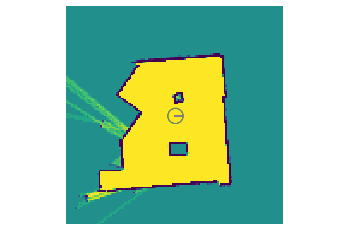

GT:  [0 0 0] PF:  [0 0 0]
GT:  [ 1.03225085e-02 -6.64233539e-08  2.51877809e-05] PF:  [1.05405694e-02 1.02226036e-05 9.69833791e-04]
GT:  [ 1.03225085e-02 -6.64233539e-08  2.51877809e-05] PF:  [1.05405694e-02 1.02226036e-05 9.69833791e-04]
GT:  [ 3.07592045e-02 -4.28553696e-06  2.75288063e-05] PF:  [2.06600203e-02 2.72705187e-05 1.68466641e-03]


KeyboardInterrupt: 

In [4]:
# Desafio patrullaje

#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Feb 14 17:34:49 2021

@author: federico
"""
# robot para la simulación
#from diffRobot import DiffRobot
# librerías varias
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.animation as animation
import matplotlib.patches as ppatches
import math
import time
import timeit
import functools
import sys

import importlib

from scipy import signal

# funciones para hacer ploteos
from ploteo_de_la_simulacion import drawRobot
from ploteo_de_la_simulacion import drawRobotPos
from ploteo_de_la_simulacion import drawLidarMeasure
from ploteo_de_la_simulacion import updatedLidarDraw

# libreria de filtro de partículas y partícual
#from particle_filter import particle
#from particle_filter import particle_filter

# ##################################################################################3

# Pose inicial REAL del robot (ground truth)
x0 = 0
y0 = 0
theta0 = 0

# Creo una instancia de DiffRobot
my_robot = DiffRobot(x0,y0,theta0)

# Cargo el mapa de grilla de ocupación
# Como resolción (metros/píxeles) uso el valor 5 metros/126 píxeles

occupation_map_file = "imagen_2021_mapa_tp.png"
occupation_map_scale_factor = 5/126

my_robot.loadOccupationMap(occupation_map_file, occupation_map_scale_factor)

# se guardan estas variables para hacer los gráficos del mapa y de la ubicación del robot
(occ_map_height, occ_map_width) = my_robot.getOccMapSizeInWorld()
occ_map = my_robot.getOccMap()

########################################################################################
# Se crea el gráfico donde se va a plottear la simulación
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.pcolormesh(np.flipud(occ_map))
ax.axis('off')
status_text = ax.text(0, -5, "")

map_center = (occ_map.shape[0] /2.0, occ_map.shape[1] / 2.0)
map_scale = (occ_map.shape[0] / occ_map_width, occ_map.shape[1] / occ_map_height)

plt.ion()
(gt_icon, gt_bearing) = drawRobot(ax, 0 + map_center[0], 0 + map_center[1], 0, my_robot.diameter * map_scale[0], 'g')
(od_icon, od_bearing) = drawRobot(ax, 0 + map_center[0], 0 + map_center[1], 0, my_robot.diameter * map_scale[0], 'grey')

plt.draw()
plt.pause(1)

lidar_values = np.zeros(my_robot.getLidarResolution())
lidarPoints = drawLidarMeasure(ax, [0 ,0 ,0], my_robot.getLidarResolution(), lidar_values)

#############################################################################################

# Se configura al robot y comienza la simulacón
my_robot.setLinearVelocity(0.1)
my_robot.setAngularVelocity(0)
my_robot.enableBumper()
my_robot.turnLidar_ON()


# variable donde guardo las lecturas del kalman filter para comparar con ground
# truth, luego de finalizada la simulación
valores_pf = []
valores_reales = []
valores_odometry = []

my_robot.startSimulation(print_status=False)
#my_robot.foward(0.2,0)
################################################################################################
# cantidad de iteraciones de la simulación
simulation_steps = 500

# Estado 1: localización, en este estado se quiere ejectuar el algoritmo de
# localización del robot
robot_state = 1

# variable que indica si está activada la rutina de localización o no
localization_on = False

paso = 1

for i in range(simulation_steps):
    #print(i)
    if(paso == 1):
        
        if(my_robot.getGroundTruth()[0] > 0.5):
            my_robot.setLinearVelocity(0)
            my_robot.setAngularVelocity(0.1)
            #print("v = 0", my_robot.getSimulationTime())
    
        if(my_robot.getGroundTruth()[2] > np.pi/2):
            my_robot.setLinearVelocity(0.1)
            my_robot.setAngularVelocity(0)
            paso = 2
            #print("v ya no es 0", my_robot.getSimulationTime())
            
        
        
    elif(paso == 2):
    
        if(my_robot.getGroundTruth()[1] > 0.8):
            my_robot.setLinearVelocity(0)
            my_robot.setAngularVelocity(0.1)
        
        if(-np.pi < my_robot.getGroundTruth()[2] < 0):
            my_robot.setLinearVelocity(0.1)
            my_robot.setAngularVelocity(0)
            paso = 3
    
    elif(paso == 3):
        
        if(my_robot.getGroundTruth()[0] < -0.5):
            my_robot.setLinearVelocity(0)
            my_robot.setAngularVelocity(0.1)
        
        if(-np.pi/2 < my_robot.getGroundTruth()[2] < 0):
            my_robot.setLinearVelocity(0.1)
            my_robot.setAngularVelocity(0)
            paso = 4
    
    elif(paso == 4):
        
        if(my_robot.getGroundTruth()[1] < 0):
            my_robot.setLinearVelocity(0)
            my_robot.setAngularVelocity(0.1)
        
        if(my_robot.getGroundTruth()[2] > 0):
            my_robot.setLinearVelocity(0.1)
            my_robot.setAngularVelocity(0)
            paso = 1
        
    
    # Estado 1: se quiere localizar al robot
    if(robot_state == 1):
        # si no se está ejecutando una rutina de localización, pero se quiere
        # comenzar a ejecutar
        
        if(localization_on == False):
            
            # inicializo el filtro de partículas
            
            error_parameters = np.array([0.10, 0.20, 0.10, 0.20, 0.25, 0.25])
            
            # número de partículas
            N = 100
            
            # inicializo el filtro de partículas
            filtro_de_particulas = particle_filter(N,error_parameters,my_robot.getLidarResolution(),np.array([0.09, 0.0, math.pi]),)
            
            # le cargo el mapa
            filtro_de_particulas.loadoccmap(occ_map,occupation_map_scale_factor)

            # indico que se está ejecutando una rutina de localización
            localization_on = True

            # instantes de tiempo de la simulación lectura de odometría del
            # robot. Se usarán para calcular después las predicciones y 
            # correcciones.
            t_old = my_robot.getSimulationTime()

            od_old = my_robot.getOdometry()
            
            resample_flag = False
            
        # si se está ejecutando una rutina de localización, se continua con esta
        else:            
            # consulto el tiempo de simulación actual para calcular el paso de
            # tiempo desde la última lectura de odometría
            t_new = my_robot.getSimulationTime()
            T = t_new - t_old
            od_new = my_robot.getOdometry()
            if(T!=0):
                (v,w) = motion_model_velocity(od_old,od_new,T)

                #filtro_de_particulas.update_particles_motion(od_old,od_new,0.1)
                #print("antes de predicción", filtro_de_particulas.best_particle_pos(),"v: ", v, "w: ", w,"dt:", T)
                filtro_de_particulas.update_particles_motion(v,w,T)
                #print("prediction:", filtro_de_particulas.best_particle_pos(),"v: ", v, "w: ", w,"dt:", T)
                od_old = od_new
                t_old = t_new
                
            #if(resample_flag == True):
            # como el resampleo tarda bastante, detengo al robot para no
            # chocarme con nada mientras resampleo
            v_old = my_robot.getLinearVelocity()
            w_old = my_robot.getAngularVelocity()
            my_robot.setLinearVelocity(0)
            my_robot.setAngularVelocity(0)
            # actualización de las partículas
            medidas = my_robot.getLidarMeaurement()
            if(medidas.all() != 0):
                filtro_de_particulas.update_particles_measurements(medidas)
            resample_flag = False
            my_robot.setLinearVelocity(v_old)
            my_robot.setAngularVelocity(w_old)
            od_old = my_robot.getOdometry()
            t_old = my_robot.getSimulationTime()
                    
        # me fijo si es necesario hacer un resampling
        desvio = filtro_de_particulas.std_err_particle_pos()
        #ESS = filtro_de_particulas.ESS()
        #if(desvio > 0.1):
        #  resample_flag = True
        #H = filtro_de_particulas.entropia()
        #print(H)
        #if(H > 1):
            #resample_flag = True

    # me guardo la pose según el filtro de kalman y la pose real para comparar
    # al final de la simulación
    
    #pose_media_particulas = filtro_de_particulas.mean_particle_pos()
    pose_media_particulas = filtro_de_particulas.best_particle_pos()
    print("GT: ", my_robot.getGroundTruth(),"PF: ", pose_media_particulas)
    valores_pf.append(pose_media_particulas)
    valores_reales.append(my_robot.getGroundTruth())
    valores_odometry.append(my_robot.getOdometry())
    
    # # The state of the robot is consulted for drawing purpose
    # # To update de draw of robot's status could take more time that
    # # simulation step (dt = 0.1 seg.)
    # # As simulation run in an independent thread the draw will be refreshing 
    # # at a lower frequency.
    # od = my_robot.getOdometry()
    # gt = my_robot.getGroundTruth()

    # # # gt_icon.set_center((gt[0] * map_scale[0] + map_center[0], gt[1] * map_scale[1] + map_center[1])) # only for Ptyhon 3
    # # gt_icon.center = gt[0] * map_scale[0] + map_center[0], gt[1] * map_scale[1] + map_center[1]
    # # #gt_icon.center = gt[0] * map_scale[0], gt[1] * map_scale[1]
    # # gt_bearing.set_xdata([gt[0] * map_scale[0] + map_center[0], gt[0] * map_scale[0] + map_center[0] + 0.5 * map_scale[0] * my_robot.diameter * np.cos(gt[2])])
    # # #gt_bearing.set_xdata([gt[0] * map_scale[0], gt[0] * map_scale[0] + 0.5 * map_scale[0] * my_robot.diameter * np.cos(gt[2])])
    # # gt_bearing.set_ydata([gt[1] * map_scale[1] + map_center[1], gt[1] * map_scale[1] + map_center[1] + 0.5 * map_scale[1] * my_robot.diameter * np.sin(gt[2])])
    # # #gt_bearing.set_ydata([gt[1] * map_scale[1], gt[1] * map_scale[1] + 0.5 * map_scale[1] * my_robot.diameter * np.sin(gt[2])])

    # gt_icon.center = gt[0] * map_scale[0] + map_center[0], gt[1] * map_scale[1] + map_center[1]
    # gt_bearing.set_xdata([gt[0] * map_scale[0] + map_center[0], gt[0] * map_scale[0] + map_center[0] + 0.5 * map_scale[0] * my_robot.diameter * np.cos(gt[2])])
    # gt_bearing.set_ydata([gt[1] * map_scale[1] + map_center[1], gt[1] * map_scale[1] + map_center[1] + 0.5 * map_scale[1] * my_robot.diameter * np.sin(gt[2])])
    
    # # # od_icon.set_center((od[0]* map_scale[0]  + map_center[0], od[1] * map_scale[1]  + map_center[1])) # only for Ptyhon 3
    # # od_icon.center = od[0]* map_scale[0]  + map_center[0], od[1] * map_scale[1]  + map_center[1]
    # # #od_icon.center = od[0]* map_scale[0], od[1] * map_scale[1]
    # # od_bearing.set_xdata([od[0] * map_scale[0] + map_center[0], od[0] * map_scale[0] + map_center[0] + 0.5 * my_robot.diameter * map_scale[0] * np.cos(od[2])])
    # # #od_bearing.set_xdata([od[0] * map_scale[0], od[0] * map_scale[0] + 0.5 * my_robot.diameter * map_scale[0] * np.cos(od[2])])
    # # od_bearing.set_ydata([od[1] * map_scale[1] + map_center[1], od[1] * map_scale[1] + map_center[1] + 0.5 * my_robot.diameter * map_scale[1] * np.sin(od[2])])
    # # #od_bearing.set_ydata([od[1] * map_scale[1], od[1] * map_scale[1] + 0.5 * my_robot.diameter * map_scale[1] * np.sin(od[2])])

    # od_icon.center = od[0]* map_scale[0]  + map_center[0], od[1] * map_scale[1]  + map_center[1]
    # od_bearing.set_xdata([od[0] * map_scale[0] + map_center[0], od[0] * map_scale[0] + map_center[0] + 0.5 * my_robot.diameter * map_scale[0] * np.cos(od[2])])
    # od_bearing.set_ydata([od[1] * map_scale[1] + map_center[1], od[1] * map_scale[1] + map_center[1] + 0.5 * my_robot.diameter * map_scale[1] * np.sin(od[2])])
    

    # lidar_values = my_robot.getLidarMeaurement()
    # updatedLidarDraw(lidarPoints, gt, lidar_values, my_robot.getLidarResolution(), map_center, map_scale)

    # v = my_robot.getLinearVelocity()
    # w = my_robot.getAngularVelocity()
    # s_text = "time = " + "{:.2f}".format(my_robot.getSimulationTime()) + "seg   u_t=(" + "{:.2f}".format(v)  + " ; " + "{:.2f}".format(w) + ") Collision = " + str(my_robot.getBumperSensorValue()) 
    # status_text.set_text(s_text)

    # plt.draw()
    # plt.pause(my_robot.dt)

    # As plot function takes time it is not needed to sleep main thread
    # if it is not the case consider to sleep main thread.
    time.sleep(my_robot.dt)
  
my_robot.stopSimulation()


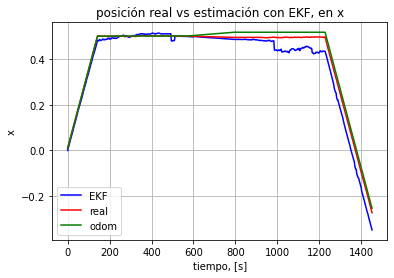

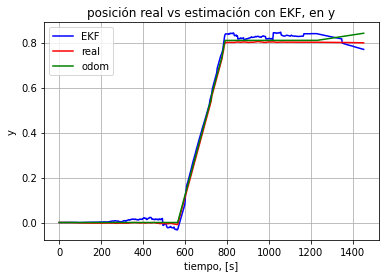

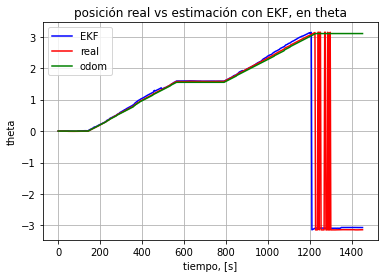

In [38]:
x_pf = []
x_real = []
x_odom = []

y_pf = []
y_real = []
y_odom = []

theta_pf = []
theta_real = []
theta_odom = []

M = len(valores_pf)

for i in range(0,M):
    x_pf.append(valores_pf[i][0])
    x_real.append(valores_reales[i][0])
    x_odom.append(valores_odometry[i][0])
    
    y_pf.append(valores_pf[i][1])
    y_real.append(valores_reales[i][1])
    y_odom.append(valores_odometry[i][1])
    
    theta_pf.append(valores_pf[i][2])
    theta_real.append(valores_reales[i][2])
    theta_odom.append(valores_odometry[i][2])
    
tiempo_sim = np.arange(0,M,1)
tiempo_sim = tiempo_sim * my_robot.getSimulationTime() / M

tiempo_plot_x = int(M)

fig1, ax1 = plt.subplots(1)
ax1.plot(tiempo_sim[0:tiempo_plot_x],x_pf[0:tiempo_plot_x],'b-',label = 'EKF')
ax1.plot(tiempo_sim[0:tiempo_plot_x],x_real[0:tiempo_plot_x],'r-',label = 'real')
ax1.plot(tiempo_sim[0:tiempo_plot_x],x_odom[0:tiempo_plot_x],'g-',label = 'odom')
ax1.set_xlabel('tiempo, [s]')
ax1.set_ylabel('x')
ax1.set_title('posición real vs estimación con EKF, en x')
ax1.grid(True)
ax1.legend()

tiempo_plot_y = int(M)
fig2, ax2 = plt.subplots(1)
ax2.plot(tiempo_sim[0:tiempo_plot_y],y_pf[0:tiempo_plot_y],'b-',label = 'EKF')
ax2.plot(tiempo_sim[0:tiempo_plot_y],y_real[0:tiempo_plot_y],'r-',label = 'real')
ax2.plot(tiempo_sim[0:tiempo_plot_x],y_odom[0:tiempo_plot_x],'g-',label = 'odom')
ax2.set_xlabel('tiempo, [s]')
ax2.set_ylabel('y')
ax2.set_title('posición real vs estimación con EKF, en y')
ax2.grid(True)
ax2.legend()

tiempo_plot_theta = int(M)
fig3, ax3 = plt.subplots(1)
ax3.plot(tiempo_sim[0:tiempo_plot_theta],theta_pf[0:tiempo_plot_theta],'b-',label = 'EKF')
ax3.plot(tiempo_sim[0:tiempo_plot_theta],theta_real[0:tiempo_plot_theta],'r-',label = 'real')
ax3.plot(tiempo_sim[0:tiempo_plot_x],theta_odom[0:tiempo_plot_x],'g-',label = 'odom')
ax3.set_xlabel('tiempo, [s]')
ax3.set_ylabel('theta')
ax3.set_title('posición real vs estimación con EKF, en theta')
ax3.grid(True)
ax3.legend()

In [35]:
  
my_robot.stopSimulation()

finishing simulation thread...
Simulation Thread Stopped


In [ ]:
a = 2
a = 1/a
a

In [ ]:
# cargar datos
from google.colab import files
uploaded = files.upload()